In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.transforms import ScaledTranslation
from matplotlib.transforms import Affine2D
import tikzplotlib
# plt.style.use(['science','bright'])
# plt.style.use(['fivethirtyeight'])
# plt.style.use(['seaborn-paper'])
# plt.style.use(['ggplot'])
plt.style.use(['default'])
plt.rcParams['text.usetex'] = True
# plt.rcParams['font.size'] = 15
plt.rcParams["font.family"] = "Times New Roman"

import pickle
import itertools
from functools import partial
import pprint
pp = pprint.PrettyPrinter(indent=4)


from util import get_loader

In [2]:
loader = get_loader()

'''NOTES:
exp = loader.find_by_id(2)
len(qs)
qs[0].to_dict()
exp.metrics.keys()
loader.find_latest().to_dict()
'''

'NOTES:\nexp = loader.find_by_id(2)\nlen(qs)\nqs[0].to_dict()\nexp.metrics.keys()\nloader.find_latest().to_dict()\n'

In [3]:
pd.set_option('display.max_columns', 500)  # or 1000
pd.set_option('display.max_rows', 500)  # or 1000

In [4]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
# change color
c_pu = colors[4]
c_gr = colors[2]
c_or = colors[1]
c_red = colors[3]
colors[2] = c_pu
colors[4] = c_gr

In [105]:
# dataset = 'music'
# dataset = 'movie'
# dataset = 'book'
# dataset = 'news'
dataset = 'nist'

usecost = True
# usecost = False

algs = ['greedy', 'greedy_w', 'greedy_sr', 'quality', 'random']
ALGS = dict([('DP','DP'),
             ('greedy','Greedy-U'),
             ('greedy_sr','AG'),
             ('greedy_w','Greedy-W'),
             ('quality','Quality'),
             ('random','Random')])

# Music

In [91]:
# loader.find_latest().to_dict()
version = 11

query = {"$and": [
    {"status": 'COMPLETED'},
    {"config.ver": version},
    {"config.usecost": usecost},
    {"config.dataset": dataset},
#     {"config.nth_sample": 0},
#     {"_id": 9},
#     {"config.dataset": "dota"}
        ]}
qs = loader.find(query)
df = qs.project(on=[
    'config.iter',
    'config.rn',
    'config.dataset',
    'config.nth_sample',
    'config.maxbudget',
    'config.method',
    
    'info.obj',
    'info.runtime',
    ])

df = df.sort_values(by=['rn','dataset','nth_sample','maxbudget'])
# df

In [92]:
df2 = df.pivot_table(index=['dataset','nth_sample','rn'], columns=['maxbudget','method'], values=['obj'])
groups = pd.MultiIndex.from_product([df2.columns.get_level_values(0).unique(), 
                                     df2.columns.get_level_values(1).unique()])
df2

obj                                               \
maxbudget               5                                            10   
method                  DP greedy greedy_sr greedy_w quality random  DP   
dataset nth_sample rn                                                     
movie   0          42   32     54        52       49      32      5  48   
                   250  24     35        35       34       0      0  49   
                   999  13     37        35       36      13      0  32   
        1          42   25     46        42       46      25      9  36   
                   250  26     40        37       38      13      4  27   
                   999  29     55        53       55       0      0  27   
        2          42   34     40        38       34      21      0  44   
                   250  19     51        49       46      19      0  40   
                   999  12     47        48       47       0      0  26   

                                                                            \
maxbudget                                                        15          
method                 greedy greedy_sr greedy_w quality random  DP greedy   
dataset nth_sample rn                                                        
movie   0          42      65        64       66      45      4  32     78   
                   250     65        61       63       9      1  44     76   
                   999     57        54       54      31      1  38     71   
        1          42      65        63       66      32      1  19     77   
                   250     53        50       50      50      2  45     70   
                   999     62        60       63       0      0  35     76   
        2          42      66        61       65      15      1  32     80   
                   250     60        58       60      19      1  47     73   
                   999     63        61       61       4      0  43     78   

                                                                               \
maxbudget                                                 20                    
method                 greedy_sr greedy_w quality random  DP greedy greedy_sr   
dataset nth_sample rn                                                           
movie   0          42         79       77      52      1  38     85        84   
                   250        74       77      30      7  34     76        75   
                   999        69       76      27      2  38     84        79   
        1          42         78       77      63      1  43     82        81   
                   250        69       71      38      1  44     76        73   
                   999        74       77      52      2  34     75        71   
        2          42         79       82      67      2  43     80        84   
                   250        71       70      39      0  25     73        72   
                   999        76       78      27     24  33     85        82   

                                                
maxbudget                                       
method                 greedy_w quality random  
dataset nth_sample rn                           
movie   0          42        87      61      6  
                   250       75      39      3  
                   999       84      33      1  
        1          42        82      50      3  
                   250       77      37      7  
                   999       76      42      2  
        2          42        84      64      4  
                   250       75      31      0  
                   999       84      31      1

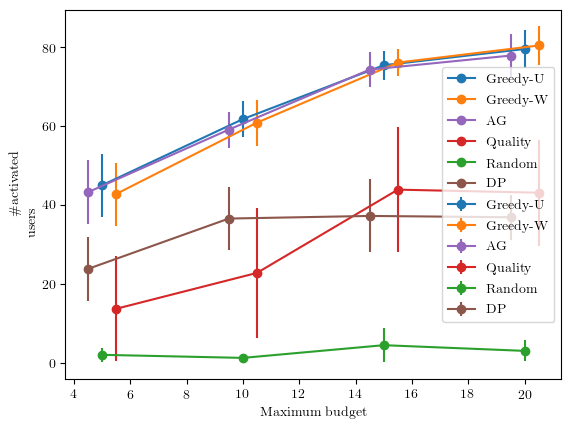

In [93]:
# usecost=True

fig, ax = plt.subplots()
trans = {'greedy_sr': Affine2D().translate(-0.5, 0.0),
         'greedy_w': Affine2D().translate(0.5, 0.0),
         'DP': Affine2D().translate(-0.5, 0.0),
         'quality': Affine2D().translate(0.5, 0.0)
        }

idx = pd.IndexSlice
ratios = []
for i in df2.index.get_level_values(1).unique().values:
    samp = df2.loc[idx[:, i, :],]
    ratio = samp.std() / (samp.mean() + 1e-9)
    ratios.append(ratio)
ratio = sum([r for r in ratios]) / len(ratios)

df3 = df2.mean()
df3_err = df2.mean() * ratio
maxbudget = df3.index.get_level_values(1).unique()
# algs = df3.index.get_level_values(2).unique()
idx = pd.IndexSlice

# for alg in algs[1:].tolist() + [algs[0]]:
for i,alg in enumerate(algs + ['DP'] if dataset!='book' else algs):
    y = df3.loc[idx[:, :, alg]].values
    err = df3_err.loc[idx[:, :, alg]].values
    bar = plt.errorbar(maxbudget, y, yerr=err, fmt='-o', label=ALGS[alg], 
                       color=colors[i],
                       transform=trans[alg]+ax.transData if alg in trans else None
                      )
    bar[0].set_label(ALGS[alg])

plt.xlabel('Maximum budget')
plt.ylabel('\#activated\\\\users')
plt.legend()

code = tikzplotlib.get_tikz_code()

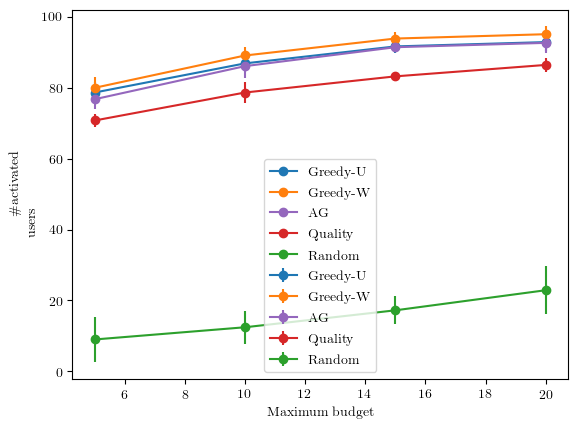

In [71]:
# usecost=False

fig, ax = plt.subplots()
trans = {'greedy_sr': Affine2D().translate(-1, 0.0),
         'greedy_w': Affine2D().translate(1, 0.0),
        }

idx = pd.IndexSlice
ratios = []
for i in df2.index.get_level_values(1).unique().values:
    samp = df2.loc[idx[:, i, :],]
    ratio = samp.std() / (samp.mean() + 1e-9)
    ratios.append(ratio)
ratio = sum([r for r in ratios]) / len(ratios)

df3 = df2.mean()
df3_err = df2.mean() * ratio
maxbudget = df3.index.get_level_values(1).unique()
# algs = df3.index.get_level_values(2).unique()
idx = pd.IndexSlice

for i,alg in enumerate(algs):
    y = df3.loc[idx[:, :, alg]].values
    err = df3_err.loc[idx[:, :, alg]].values
    bar = plt.errorbar(maxbudget, y, yerr=err, fmt='-o', label=ALGS[alg], 
                       c=colors[i],
#                        transform=trans[alg]+ax.transData if alg in trans else None # only movie
                      )
    bar[0].set_label(ALGS[alg])

plt.xlabel('Maximum budget')
plt.ylabel('\#activated\\\\users')
plt.legend()

code = tikzplotlib.get_tikz_code()

# 20 News

In [96]:
# loader.find_latest().to_dict()
version = 11

query = {"$and": [
    {"status": 'COMPLETED'},
    {"config.ver": version},
    {"config.usecost": usecost},
    {"config.dataset": dataset},
#     {"_id": 9},
#     {"config.dataset": "dota"}
        ]}
qs = loader.find(query)
df = qs.project(on=[
    'config.iter',
    'config.rn',
    'config.dataset',
    'config.nth_sample',
    'config.maxbudget',
    'config.method',
    
    'info.obj',
    'info.runtime',
    ])

df = df.sort_values(by=['rn','dataset','nth_sample','maxbudget'])
# df

In [97]:
df2 = df.pivot_table(index=['dataset','nth_sample','rn'], columns=['maxbudget','method'], values=['obj'])
groups = pd.MultiIndex.from_product([df2.columns.get_level_values(0).unique(), 
                                     df2.columns.get_level_values(1).unique()])
df2

obj                                                 \
maxbudget                  2                                              4   
method                    DP greedy greedy_sr greedy_w quality random    DP   
dataset nth_sample rn                                                         
news    0          42   2.65   3.30      3.15     3.25     0.0   2.30  2.60   
                   250  2.20   2.90      2.65     2.95     0.0   1.45  1.65   
                   999  2.55   2.85      2.70     2.95     0.0   1.65  2.80   
        1          42   1.30   3.30      3.05     3.35     0.0   1.25  2.30   
                   250  1.25   2.60      2.20     2.60     0.0   0.60  1.85   
                   999  1.55   3.15      2.80     3.35     0.0   1.95  2.25   
        2          42   2.15   3.00      2.45     3.15     0.0   0.20  2.65   
                   250  1.70   2.95      2.85     3.30     0.0   0.30  2.50   
                   999  1.55   3.15      3.05     3.20     0.0   1.00  1.60   
        3          42   1.95   2.70      2.55     2.90     0.0   1.75  2.00   
                   250  1.90   2.45      2.05     2.45     0.0   1.05  3.25   
                   999  1.55   2.70      2.45     2.80     0.0   1.45  2.00   
        4          42   1.15   2.55      2.30     2.85     0.0   1.55  1.75   
                   250  1.75   2.85      2.75     2.85     0.0   0.00  1.70   
                   999  1.25   1.65      1.65     1.80     0.0   0.00  1.55   
        5          42   1.30   2.25      2.05     2.25     0.0   0.85  2.45   
                   250  1.95   2.70      2.65     2.75     0.0   1.20  1.95   
                   999  1.15   1.45      1.05     1.40     0.0   0.20  1.85   
        6          42   1.70   2.95      2.70     3.10     0.0   0.20  2.35   
                   250  1.50   2.85      2.05     2.85     0.0   0.80  2.20   
                   999  1.45   1.40      1.15     1.40     0.0   0.60  2.40   
        7          42   2.50   3.30      2.80     3.40     0.0   2.80  3.40   
                   250  2.85   3.15      2.30     3.15     0.0   0.60  3.85   
                   999  2.90   3.15      3.10     3.30     0.0   2.15  3.60   
        8          42   1.80   2.10      1.90     2.15     0.0   0.25  2.05   
                   250  1.50   1.90      1.90     2.10     0.0   1.40  1.60   
                   999  1.35   2.05      1.50     2.15     0.0   1.20  1.60   
        9          42   1.00   2.30      2.15     2.35     0.0   0.60  2.10   
                   250  1.40   2.75      2.80     2.85     0.0   0.20  1.50   
                   999  1.55   2.50      2.55     2.65     0.0   0.50  1.30   

                                                                              \
maxbudget                                                           6          
method                 greedy greedy_sr greedy_w quality random    DP greedy   
dataset nth_sample rn                                                          
news    0          42    3.55      3.35     3.60     0.0   2.95  2.80   3.70   
                   250   3.95      3.60     3.95     0.0   2.35  2.95   4.20   
                   999   4.15      4.05     4.15     0.0   3.10  2.80   4.15   
        1          42    3.30      3.05     3.60     0.0   1.10  2.10   3.50   
                   250   3.55      3.35     3.75     0.0   0.60  1.60   4.30   
                   999   3.65      3.30     3.70     0.0   2.30  2.60   4.55   
        2          42    3.65      3.60     3.80     0.0   1.05  2.15   3.45   
                   250   4.15      4.05     4.20     0.0   0.30  2.00   4.35   
                   999   4.00      3.90     4.05     0.0   2.05  1.75   4.10   
        3          42    3.10      3.00     3.25     0.0   2.45  1.90   3.25   
                   250   3.85      3.70     4.00     0.0   2.20  3.10   3.75   
                   999   3.65      3.35     3.60     0.0   2.40  2.00   3.65   
        4          42    3.50      3.45     3.80     0.0  

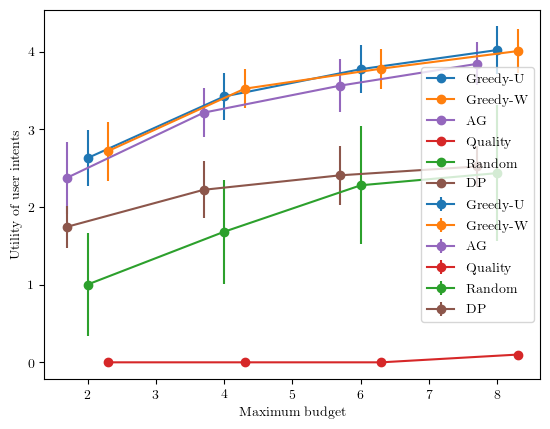

In [103]:
# usecost=True

fig, ax = plt.subplots()
trans = {'greedy_sr': Affine2D().translate(-0.3, 0.0),
         'greedy_w': Affine2D().translate(0.3, 0.0),
         'DP': Affine2D().translate(-0.3, 0.0),
         'quality': Affine2D().translate(0.3, 0.0)
        }


idx = pd.IndexSlice
ratios = []
for i in df2.index.get_level_values(1).unique().values:
    samp = df2.loc[idx[:, i, :],]
    ratio = samp.std() / (samp.mean() + 1e-9)
    ratios.append(ratio)
ratio = sum([r for r in ratios]) / len(ratios)

df3 = df2.mean()
df3_err = df2.mean() * ratio
maxbudget = df3.index.get_level_values(1).unique()
# algs = df3.index.get_level_values(2).unique()
idx = pd.IndexSlice

for i,alg in enumerate(algs + ['DP']):
    y = df3.loc[idx[:, :, alg]].values
    err = df3_err.loc[idx[:, :, alg]].values
    bar = plt.errorbar(maxbudget, y, yerr=err, fmt='-o', label=ALGS[alg],
                       c=colors[i], 
                       transform=trans[alg]+ax.transData if alg in trans else None
                      )
    bar[0].set_label(ALGS[alg])

plt.xlabel('Maximum budget')
plt.ylabel('Utility of user intents')
plt.legend()

code = tikzplotlib.get_tikz_code()

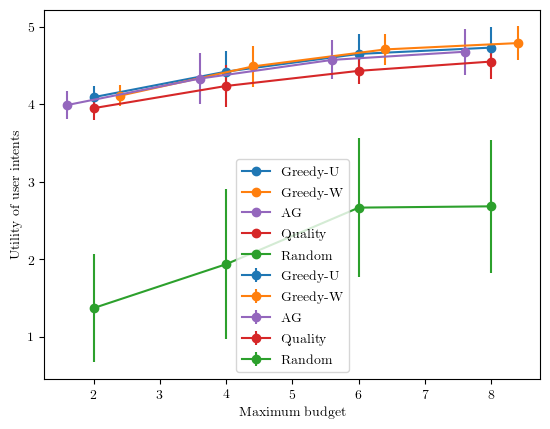

In [51]:
# usecost=False

fig, ax = plt.subplots()
trans = {'greedy_sr': Affine2D().translate(-0.4, 0.0),
         'greedy_w': Affine2D().translate(0.4, 0.0)}

idx = pd.IndexSlice
ratios = []
for i in df2.index.get_level_values(1).unique().values:
    samp = df2.loc[idx[:, i, :],]
    ratio = samp.std() / (samp.mean() + 1e-9)
    ratios.append(ratio)
ratio = sum([r for r in ratios]) / len(ratios)

df3 = df2.mean()
df3_err = df2.mean() * ratio
maxbudget = df3.index.get_level_values(1).unique()
# algs = df3.index.get_level_values(2).unique()
idx = pd.IndexSlice

for i,alg in enumerate(algs):
    y = df3.loc[idx[:, :, alg]].values
    err = df3_err.loc[idx[:, :, alg]].values
    bar = plt.errorbar(maxbudget, y, yerr=err, fmt='-o', label=ALGS[alg], 
                       c=colors[i],
                       transform=trans[alg]+ax.transData if alg in trans else None)
    bar[0].set_label(ALGS[alg])
    
plt.xlabel('Maximum budget')
plt.ylabel('Utility of user intents')
plt.legend()

code = tikzplotlib.get_tikz_code()

# NIST

In [106]:
# loader.find_latest().to_dict()
version = 11

query = {"$and": [
    {"status": 'COMPLETED'},
    {"config.ver": version},
    {"config.usecost": usecost},
#     {"config.usecost": True},
#     {"config.maxbudget": {'$ne': 80}},
#     {"_id": 9},
    {"config.dataset": dataset},
        ]}
qs = loader.find(query)
df = qs.project(on=[
    'config.iter',
    'config.rn',
    'config.dataset',
    'config.nth_sample',
    'config.maxbudget',
    'config.method',
    
    'info.obj',
    'info.acc',
    'info.runtime',
    ])

df = df[df['dataset'] == dataset]
df = df.sort_values(by=['rn','dataset','nth_sample','maxbudget'])
# df

In [107]:
df2 = df.pivot_table(index=['dataset','nth_sample','rn'], columns=['maxbudget','method'], values=['obj','acc'])
groups = pd.MultiIndex.from_product([df2.columns.get_level_values(0).unique(), 
                                     df2.columns.get_level_values(1).unique()])
df2

acc                                          \
maxbudget                    25                                            
method                        DP    greedy greedy_sr  greedy_w   quality   
dataset nth_sample rn                                                      
nist    0          42   0.114074  0.640000  0.636296  0.644444  0.066667   
                   250  0.082963  0.463704  0.457037  0.463704  0.074815   
                   999  0.030370  0.151852  0.157778  0.176296  0.000000   
        1          42   0.126667  0.642963  0.642963  0.640741  0.063704   
                   250  0.116296  0.481481  0.462222  0.474815  0.063704   
                   999  0.063704  0.145185  0.156296  0.130370  0.000000   
        2          42   0.123704  0.614074  0.602222  0.622222  0.118519   
                   250  0.075556  0.466667  0.480000  0.466667  0.079259   
                   999  0.087407  0.128148  0.139259  0.128148  0.000000   

                                                                          \
maxbudget                              50                                  
method                    random        DP    greedy greedy_sr  greedy_w   
dataset nth_sample rn                                                      
nist    0          42   0.200000  0.106667  0.770370  0.774815  0.775556   
                   250  0.125185  0.100000  0.782963  0.791852  0.769630   
                   999  0.000000  0.066667  0.522222  0.529630  0.532593   
        1          42   0.191111  0.097778  0.788148  0.780741  0.777037   
                   250  0.097037  0.095556  0.742222  0.743704  0.721481   
                   999  0.000000  0.063704  0.539259  0.540000  0.523704   
        2          42   0.150370  0.091111  0.765185  0.763704  0.775556   
                   250  0.107407  0.113333  0.761481  0.754074  0.751852   
                   999  0.000000  0.065185  0.525926  0.537037  0.530370   

                                                                          \
maxbudget                                        75                        
method                   quality    random        DP    greedy greedy_sr   
dataset nth_sample rn                                                      
nist    0          42   0.117778  0.375556  0.100000  0.820000  0.814815   
                   250  0.119259  0.288148  0.765926  0.834074  0.845185   
                   999  0.085926  0.174074  0.790370  0.834074  0.831111   
        1          42   0.118519  0.320000  0.095556  0.795556  0.787407   
                   250  0.118519  0.328148  0.734074  0.822222  0.825185   
                   999  0.063704  0.236296  0.759259  0.845185  0.845926   
        2          42   0.131111  0.271852  0.113333  0.823704  0.827407   
                   250  0.133333  0.268889  0.714815  0.830370  0.833333   
                   999  0.088889  0.192593  0.746667  0.842222  0.848148   

                                                                          \
maxbudget                                                  100             
method                  greedy_w   quality    random        DP    greedy   
dataset nth_sample rn                                                      
nist    0          42   0.816296  0.139259  0.363704  0.106667  0.811111   
                   250  0.839259  0.141481  0.220741  0.808889  0.855556   
                   999  0.840741  0.140741  0.372593  0.812593  0.873333   
        1          42   0.796296  0.171852  0.317778  0.097778  0.811111   
                   250  0.829630  0.148148  0.401481  0.817037  0.884444   
                   999  0.835556  0.189630  0.414074  0.831111  0.894074   
        2          42   0.825185  0.148889  0.403704  0.091111  0.811111   
                   250  0.825185  0.128889  0.365926  0.820741  0.867407   
                   999  0.839259  0.129630  0.410370  0.805926  0.852593   

                                                                     obj 

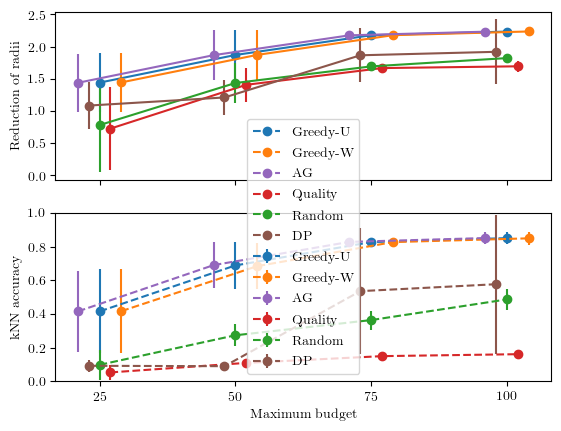

In [108]:
trans = {'greedy_sr': Affine2D().translate(-4, 0.0),
         'greedy_w': Affine2D().translate(4, 0.0),
         'DP': Affine2D().translate(-2, 0.0),
         'quality': Affine2D().translate(2, 0.0)
        }


idx = pd.IndexSlice
ratios = []
for i in df2.index.get_level_values(1).unique().values:
    samp = df2.loc[idx[:, i, :],]
    ratio = samp.std() / (samp.mean() + 1e-9)
    ratios.append(ratio)
ratio = sum([r for r in ratios]) / len(ratios)

df3 = df2.mean()
df3_err = df2.mean() * ratio
maxbudget = df3.index.get_level_values(1).unique()
# algs = df3.index.get_level_values(2).unique()
algs_ = algs + ['DP'] if usecost else algs

fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True)

ax = axes.flatten()[0]
ls = '-'
tar = 'obj'
ax.set_ylabel('Reduction of radii')
for i,alg in enumerate(algs_):
    y = df3.loc[idx[tar, :, alg]].values
    err = df3_err.loc[idx[tar, :, alg]].values
    bar = ax.errorbar(maxbudget, y, yerr=err, fmt='-o', label=ALGS[alg], ls=ls, 
                      c=colors[i], transform=trans[alg]+ax.transData if alg in trans else None)
    bar[0].set_label(ALGS[alg])

ax = axes.flatten()[1]
ls = '--'
tar = 'acc'
ax.set_ylabel('kNN accuracy')
ax.set_ylim((0,1))
for i,alg in enumerate(algs_):
    y = df3.loc[idx[tar, :, alg]].values
    err = df3_err.loc[idx[tar, :, alg]].values
    bar = ax.errorbar(maxbudget, y, yerr=err, fmt='-o', label=ALGS[alg], ls=ls, 
                      c=colors[i], transform=trans[alg]+ax.transData if alg in trans else None)
    bar[0].set_label(ALGS[alg])

# fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.xticks(maxbudget)
plt.xlabel('Maximum budget')
plt.legend()

code = tikzplotlib.get_tikz_code()

# Running time

In [19]:
dataset = 'runtime'

usecost = True

# is_scale_budget = True
is_scale_budget = False

In [20]:
# loader.find_latest().to_dict()
version = 10

query = {"$and": [
    {"status": 'COMPLETED'},
    {"config.ver": version},
    {"config.iter": 1},
    {"config.usecost": usecost},
    {"config.dataset": dataset},
    {"config.nth_sample": 99} if is_scale_budget else {"config.maxbudget": 99},
        ]}
qs = loader.find(query)
df = qs.project(on=[
    'config.iter',
    'config.rn',
    'config.dataset',
    'config.nth_sample',
    'config.maxbudget',
    'config.method',
    
    'info.obj',
    'info.runtime',
    ])

df = df.sort_values(by=['rn','dataset','nth_sample','maxbudget'])

df2 = df.pivot_table(index=['dataset','rn'], 
                     columns=['maxbudget' if is_scale_budget else 'nth_sample','method'], 
                     values=['runtime'])
groups = pd.MultiIndex.from_product([df2.columns.get_level_values(0).unique(), 
                                     df2.columns.get_level_values(1).unique()])
df2

runtime                                                   \
nth_sample     10                                                       
method            DP    greedy greedy_sr  greedy_w   quality   random   
dataset rn                                                              
runtime 42  0.132959  0.050233   0.15092  0.047852  0.013993  0.00004   

                                                                        \
nth_sample      100                                                      
method             DP   greedy greedy_sr  greedy_w   quality    random   
dataset rn                                                               
runtime 42  12.836611  0.62703  2.618954  0.551393  0.140254  0.000037   

                                                                           \
nth_sample        1000                                                      
method               DP    greedy  greedy_sr  greedy_w   quality   random   
dataset rn                                                                  
runtime 42  1741.146113  8.224133  28.289342  8.613277  1.340759  0.00004   

                                                                  
nth_sample      10000                                             
method         greedy   greedy_sr   greedy_w    quality   random  
dataset rn                                                        
runtime 42  83.391841  298.566623  87.559527  13.681022  0.00005

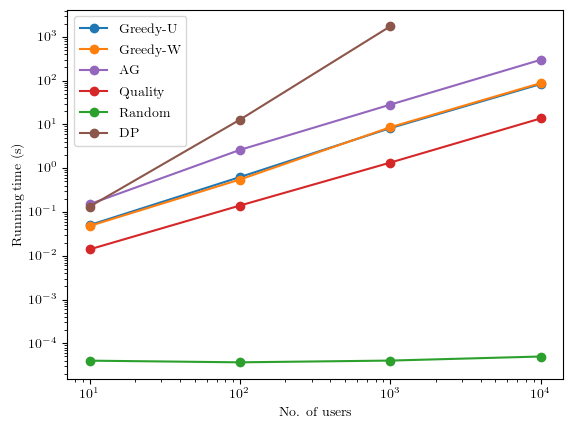

In [21]:
# usecost=True

df3 = df2.mean()
maxbudget = df3.index.get_level_values(1).unique()
# algs = df3.index.get_level_values(2).unique()
idx = pd.IndexSlice

for i,alg in enumerate(algs+['DP']):
    y = df3.loc[idx[:, :, alg]].values
    if len(y) < len(maxbudget):
        y = y.tolist() + [np.nan]
    plt.plot(maxbudget, y, marker='o', label=ALGS[alg], c=colors[i])

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Maximum budget' if is_scale_budget else 'No. of users')
plt.ylabel('Running time (s)')
plt.legend()

code = tikzplotlib.get_tikz_code()

In [22]:
# Running time

opt = '''width = 0.35\\textwidth, height = 0.3\\textwidth, 
minor tick style={draw=none}, 
legend style={
  legend pos=outer north east
},
ytick={1e-5, 1e-1, 1e3},'''
code = code.replace('\\begin{axis}[', '\\begin{axis}[' + opt)

code = code.replace(']\n\\addplot', ', legend style={at={(1.2,1)}, anchor=north west}' + ']\n\\addplot')

opt = '\\legend{}'
code = code.replace('\\end{axis}', opt + '\\end{axis}')
code = code.replace('mark size=3', 'mark size=1.5')

with open(f'tikz/time-{dataset}-usecost{usecost}-scalebudget{is_scale_budget}.tex', 'w') as fout:
    fout.write(code)

# Tikz

In [109]:
def add_opt(code, key, opt, beg=False):
    idx = code.find(key)
    if beg:
        return code[:idx] + opt + code[idx:]
    return code[:idx+len(key)] + opt + code[idx+len(key):]

if dataset in ['music', 'movie', 'book']:
    code = code.replace('mark size=3', 'mark size=1')
    opt = '''width = 0.3\\textwidth, height = 0.25\\textwidth, legend image post style={scale=0.4}, ylabel style={align=center},'''
elif dataset == 'nist':
    opt = '''width = 0.35\\textwidth, height = 0.3\\textwidth, ylabel style={align=center}, group/vertical sep=20pt, xtick={25,50,75,100},'''
else:
#     opt = '''width = 0.35\\textwidth, height = 0.3\\textwidth, legend style={legend pos=outer north east},'''
    opt = '''width = 0.35\\textwidth, height = 0.3\\textwidth, '''
# code = add_opt(code, '\\begin{axis}[', opt)
key = 'begin{groupplot}[' if dataset == 'nist' else '\\begin{axis}['
code = code.replace(key, key + opt)

if dataset in ['music', 'movie', 'book']:
    code = code.replace(']\n\\path', ', legend style={at={(0.25,1.9)},anchor=north,legend columns=2,font=\scriptsize}' + ']\n\\path')
else:
    code = code.replace(']\n\\path', ', legend style={at={(1.2,1)}, anchor=north west}' + ']\n\\path')

opt = '\\legend{}'
key = '\\end{groupplot}' if dataset == 'nist' else '\\end{axis}'
code = code.replace(key, opt + key)

code = code.replace('mark size=3', 'mark size=1.5')

with open(f'tikz/{dataset}-usecost{usecost}.tex', 'w') as fout:
    fout.write(code)